# Car detection

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-4.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Implement object detection for autonomous driving using the [YOLO (You Only Look Once)](https://arxiv.org/pdf/1506.02640) object detection system.

**YOLO** is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. It outputs recognized objects together with the bounding boxes.

## Download YAD2K (Yet Another Darknet 2 Keras)

[YAD2K](https://github.com/allanzelener/YAD2K) is a repository that helps convert the [Darknet](https://pjreddie.com/darknet/) YOLOv2 model to a Keras model and test it. The YAD2K was modified to work with [Keras 3](https://keras.io/keras_3/).

In [1]:
%%bash

gdown -q 1MA4g7d-pJEChYey2PotscZXq9EJr0K2H
unzip -q ./YAD2K.zip
rm ./YAD2K.zip

## Import libraries

In [2]:
from YAD2K.yad2k.utils.utils import preprocess_image, read_classes, read_anchors, draw_boxes
from YAD2K.yad2k.models.keras_yolo import space_to_depth_x2, space_to_depth_x2_output_shape, yolo_head, yolo_eval
import os
from keras import models
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML

2024-06-28 01:08:59.306243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualize the dataset

In [3]:
path = "./YAD2K/images/"
files = [path + file for file in sorted(os.listdir(path)) if ".jpg" in file and file.startswith("0")]
frames = []

fig, ax = plt.subplots()

for file in files:
    image = Image.open(file)
    plt.tight_layout()
    ax.axis("off")
    frame = ax.imshow(image, animated=True)
    frames.append([frame])
    
anim = animation.ArtistAnimation(fig, frames, blit=True, repeat_delay=1000)
plt.close(fig)

HTML(anim.to_html5_video())

## Download Darknet model cfg and weights from the YOLO website

In [4]:
%%bash

wget -q https://pjreddie.com/media/files/yolov2.weights -P ./YAD2K/model_data/
wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov2.cfg -P ./YAD2K/model_data/

## Convert the Darknet YOLOv2 model to a Keras model

In [5]:
!./YAD2K/yad2k.py ./YAD2K/model_data/yolov2.cfg ./YAD2K/model_data/yolov2.weights ./YAD2K/model_data/yolov2.keras

2024-06-28 01:10:52.664830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Loading weights...
Parsing Darknet config...
Creating Keras model...
2024-06-28 01:10:54.994264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2026 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
Concatenating route layers: [<KerasTensor shape=(None, 19, 19, 256), dtype=float32, sparse=False, name=keras_tensor_69>, <KerasTensor shape=(None, 19, 19, 1024), dtype=float32, sparse=False, name=keras_tensor_65>]
Saved Keras model to ./YAD2K/model_data/yolov2.keras
Read 50983561 of 50983561 from Darknet weights!


## Load the pre-trained YOLOv2 model, [COCO](https://cocodataset.org/) classes and anchor boxes

In [6]:
model = models.load_model("./YAD2K/model_data/yolov2.keras", 
                          custom_objects={'space_to_depth_x2': space_to_depth_x2, 'space_to_depth_x2_output_shape': space_to_depth_x2_output_shape})

classes = read_classes("./YAD2K/model_data/coco_classes.txt")
anchors = read_anchors("./YAD2K/model_data/yolov2_anchors.txt")

2024-06-28 01:10:57.718533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2022 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Test the YOLOv2 model on a simple image

2024-06-28 01:11:03.016489: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-28 01:11:03.485753: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-28 01:11:03.572175: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-28 01:11:03.682505: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

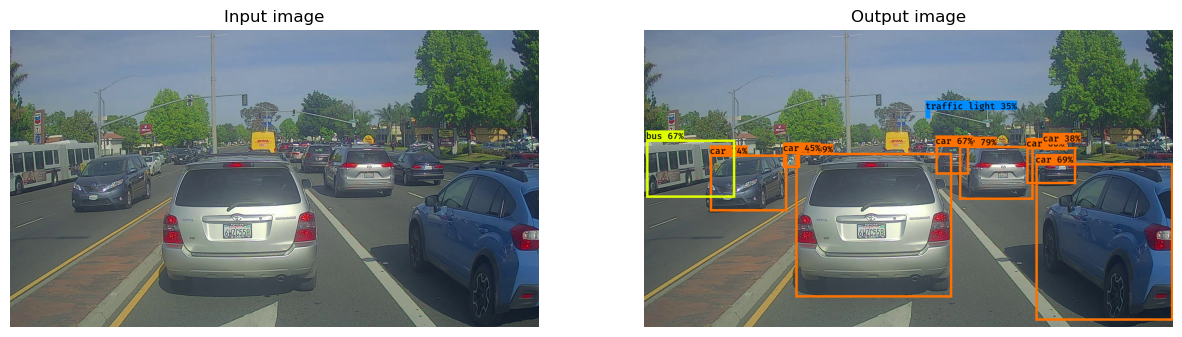

In [7]:
file = "./YAD2K/images/test.jpg"
image, image_data = preprocess_image(file, model_image_size=(608, 608))
model_outputs = model(image_data)
outputs = yolo_head(model_outputs, anchors, len(classes))
out_boxes, out_scores, out_classes = yolo_eval(outputs, [image.size[1], image.size[0]], score_threshold=0.3, iou_threshold=0.5)
output_image = draw_boxes(image.copy(), out_boxes, out_classes, classes, out_scores)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))

axs[0].imshow(image)
axs[0].axis("off")
axs[0].set_title("Input image")

axs[1].imshow(output_image)
axs[1].axis("off")
axs[1].set_title("Output image")

plt.show()

## Evaluate the YOLOv2 model on the full dataset

In [8]:
path = "./YAD2K/images/"
files = [path + file for file in sorted(os.listdir(path)) if ".jpg" in file and file.startswith("0")]
frames = []

fig, ax = plt.subplots()

for file in files:
    image, image_data = preprocess_image(file, model_image_size=(608, 608))
    model_outputs = model(image_data)
    outputs = yolo_head(model_outputs, anchors, len(classes))
    out_boxes, out_scores, out_classes = yolo_eval(outputs, [image.size[1], image.size[0]], score_threshold=0.3, iou_threshold=0.5)
    output_image = draw_boxes(image.copy(), out_boxes, out_classes, classes, out_scores)
    
    plt.tight_layout()
    ax.axis("off")
    frame = ax.imshow(output_image, animated=True)
    frames.append([frame])
    
anim = animation.ArtistAnimation(fig, frames, blit=True, repeat_delay=1000)
plt.close(fig)

HTML(anim.to_html5_video())

In [9]:
!rm -rf ./YAD2K